<a href="https://colab.research.google.com/github/navanil2702/Airbnb-analysis/blob/main/Airbnb_Price_Prediction_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Install required packages (if needed)
!pip install -q scikit-learn pandas

In [ ]:
# STEP 2: Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

In [ ]:
# STEP 3: Upload CSV manually or use Google Drive
from google.colab import files
uploaded = files.upload()  # Upload 'AB NYC 2019.csv'

Saving AB NYC 2019.csv to AB NYC 2019 (1).csv


In [ ]:
# STEP 4: Load data
df = pd.read_csv('AB NYC 2019.csv')

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MAE: 42.69
R²: 0.63


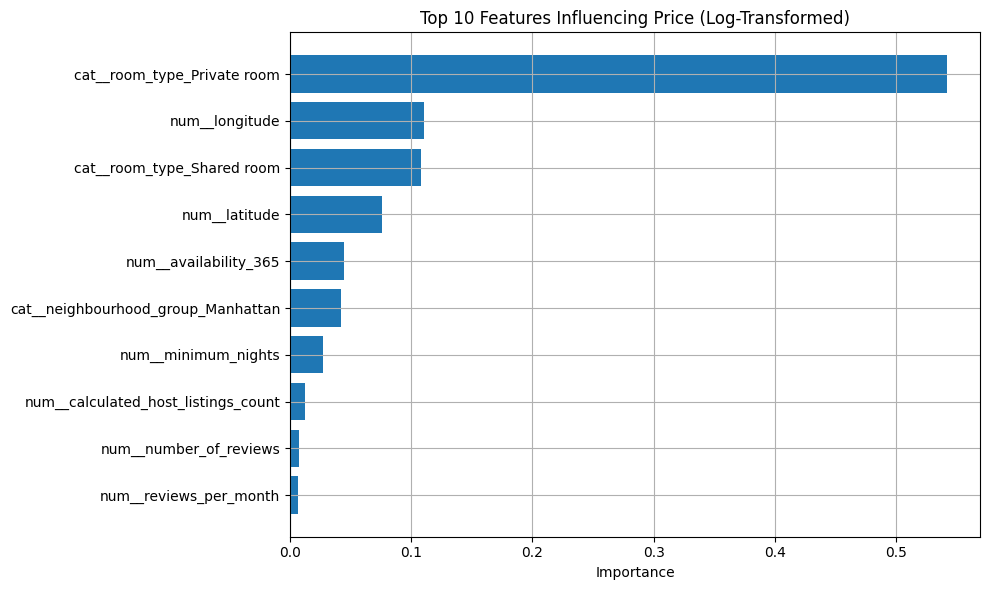

In [ ]:
# STEP 5: Feature Engineering
df_clean = df[['neighbourhood_group', 'neighbourhood', 'room_type', 'latitude', 'longitude',
               'minimum_nights', 'number_of_reviews', 'reviews_per_month',
               'calculated_host_listings_count', 'availability_365', 'price', 'last_review']]

df_clean = df_clean.dropna(subset=['reviews_per_month', 'last_review'])
df_clean = df_clean[(df_clean['price'] > 10) & (df_clean['price'] < 1000)]

df_clean['last_review'] = pd.to_datetime(df_clean['last_review'])
df_clean['review_month'] = df_clean['last_review'].dt.month
df_clean.drop(columns=['last_review'], inplace=True)

# Target and features
y = np.log1p(df_clean['price'])  # log(price)
X = df_clean.drop(columns='price')

# Preprocessing
cat_features = ['neighbourhood_group', 'neighbourhood', 'room_type']
num_features = [col for col in X.columns if col not in cat_features]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_features),
    ('num', SimpleImputer(strategy='mean'), num_features)
])

# Model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(n_estimators=100, max_depth=4, random_state=42))
])

# Train-test split (no CV for speed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
from sklearn.metrics import mean_absolute_error, r2_score
print(f"MAE: {mean_absolute_error(np.expm1(y_test), np.expm1(y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

# Feature importances
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = model.named_steps['regressor'].feature_importances_

top_idx = np.argsort(importances)[-10:]
top_features = feature_names[top_idx]
top_values = importances[top_idx]

plt.figure(figsize=(10,6))
plt.barh(top_features, top_values)
plt.xlabel("Importance")
plt.title("Top 10 Features Influencing Price (Log-Transformed)")
plt.grid(True)
plt.tight_layout()
plt.show()